# 1. Install important dependencies

In [8]:
# # Install necessary packages
# !pip install transformers nltk datasets numpy seaborn pandas scikit-learn matplotlib
# !pip install torch
# !pip install mlxtend
# !pip install accelerate>=0.20.1
# !pip install tensorflow

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# 2. Import Dependencies

In [13]:
import pandas as pd
import os
import re
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# To import the Transformer Models
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

import torch
from torch import nn

# to convert to Dataset datatype - the transformers library does not work well with pandas
from datasets import Dataset

import warnings
warnings.filterwarnings("ignore")

### 2.1 Loading the dataset

In [4]:
# The dataset does not contain class labels, so we need to explicitly provide it
df=pd.read_csv("train.csv")
df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [5]:
df = df.rename(columns={'Class Index':'label'})
df.head()

,label,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


### 2.2 Checking each class data count

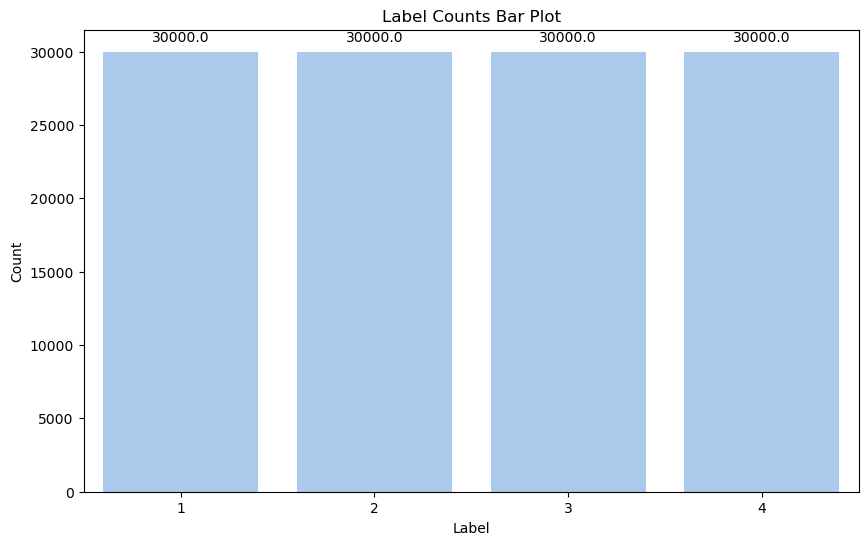

In [6]:
# For train data - checking for unbalanced dataset

value_counts = df['label'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.set_palette("pastel")  # Use a pastel color palette

# Plotting the bar plot
ax = sns.barplot(x=value_counts.index, y=value_counts.values)

# Adding labels and title
ax.set(xlabel='Label', ylabel='Count', title='Label Counts Bar Plot')

# Display the counts on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

### Note:
    1) Each class contains "30,000" training samples.
    2) The dataset is evenly distributed. Therefore, there is no need for oversampling/undersampling of the classes.

### 2.3 Checking for null values

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   label        120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


# 3. Data Preprocessing

### 3.1)  Making changes to the original dataframes
    1) We're being provided with two columns : Title & Description
    2) We obtain most of the information from the title itself.
    3)  So, it's a better choice to merge the title and description columns with the title column being first. And drop Title & Description column

In [8]:
# concatinating the 'title' and 'description' column
df['text']=(df['Title']+" "+df['Description'])

# We no longer needed separate title and description columns so I'll drop them
df.drop(columns=['Title','Description'],axis=1,inplace=True)

df.head()

,label,text
0,3,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new..."


In [9]:
# Text before preprocessing - contains symbols like ()\-,.' which is not useful
for i in range(0,4):
    print(df['text'][i])
    print("------------------------------------------")
    print()

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
------------------------------------------

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
------------------------------------------

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
------------------------------------------

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, 

### 3.2 Remove Punctuations and unnecessary letters

In [10]:
import re   # regular expression can be used to remove any punctuation or unnecessary symbols

In [11]:
def remove_punctuations(text):
    text=re.sub(r'[\\-]',' ',text)
    text=re.sub(r'[,.?;:\'(){}!|0-9]','',text)
    return text

# the apply method applies a function along an axis of dataframe
df['text']=df['text'].apply(remove_punctuations)
df['label']=df['label']-1

df.head()

,label,text
0,2,Wall St Bears Claw Back Into the Black Reuters...
1,2,Carlyle Looks Toward Commercial Aerospace Reut...
2,2,Oil and Economy Cloud Stocks Outlook Reuters R...
3,2,Iraq Halts Oil Exports from Main Southern Pipe...
4,2,Oil prices soar to all time record posing new ...


In [12]:
df['text'] = df['text'].apply(lambda x: x.lower())


In [13]:
df['text'][1]   # this is the final preprocessed text

'carlyle looks toward commercial aerospace reuters reuters   private investment firm carlyle group which has a reputation for making well timed and occasionally controversial plays in the defense industry has quietly placed its bets on another part of the market'

### 3.3 Split the train.csv data into training and testing sets

In [14]:
from sklearn.model_selection import train_test_split

# since training on the full dataset(120,000 samples) would be take so long, the train size is only taken to be 30%
train_df,test_df=train_test_split(df[['text','label']],test_size=.30,shuffle=True)


In [15]:
train_df.shape,test_df.shape    # training set has 36000 samples and testing set has 10000 samples

((84000, 2), (36000, 2))

### 3.4 Loading a pre-built tokenizer and convert to tokens

In [16]:
# load tokenizer from bert base uncased model available from huggingface.co

model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [17]:
# Note:
# Initializes a sequence classification model, loads pre-trained weights, and then customizes the model to freeze 
# all parameters except for the last two layers of the transformer encoder, which are unfrozen for fine-tuning on the 
# specific classification task.

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

# Customize model to train only last 2 layers
for param in model.base_model.parameters():
    param.requires_grad = False  # Freeze all parameters initially

for param in model.base_model.encoder.layer[-2:].parameters():
    param.requires_grad = True  # Unfreeze last two layers

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
def preprocess_function(examples):
    """
    Tokenizes the given text

    input -> dataset (columns = text, label)
    output -> tokenized dataset (columns = text, label, input, attention)
    """
    return tokenizer(examples["text"], truncation=True)

def pipeline(dataframe):
    """
    Prepares the dataframe so that it can be given to the transformer model
    
    input -> pandas dataframe
    output -> tokenized dataset (columns = text, label, input, attention)
    """    
    dataset = Dataset.from_pandas(dataframe, preserve_index=False)
    tokenized_ds = dataset.map(preprocess_function, batched=True)
    tokenized_ds = tokenized_ds.remove_columns('text')
    return tokenized_ds

In [19]:
# create pipeline for training data and testing data
tokenized_train = pipeline(train_df)
tokenized_test = pipeline(test_df)

Map:   0%|          | 0/84000 [00:00<?, ? examples/s]

Map:   0%|          | 0/36000 [00:00<?, ? examples/s]

# 4. Load a pre-trained model

### 4.1 Adjust Model training arguments

In [20]:

# Training arguments
training_args = TrainingArguments(
    output_dir="./results_2",        #directory where model checkpoints and training outputs will be saved.
    save_strategy='epoch',
    optim='adamw_torch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,     # regularization term that penalizes large weights in the model.
)



In [21]:
# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)   # process batches of data, ensuring that padding is applied as needed.

# Trainer initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

### 4.2 Train the model

In [22]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.496000
1000,0.309000
1500,0.289900
2000,0.259500
2500,0.270500
3000,0.277100
3500,0.253000
4000,0.257800
4500,0.242200
5000,0.247900


TrainOutput(global_step=15750, training_loss=0.23302848573714968, metrics={'train_runtime': 6931.2137, 'train_samples_per_second': 36.357, 'train_steps_per_second': 2.272, 'total_flos': 1.0301854361779968e+16, 'train_loss': 0.23302848573714968, 'epoch': 3.0})

In [23]:
trainer.evaluate()

{'eval_loss': 0.21727338433265686,
 'eval_runtime': 677.8221,
 'eval_samples_per_second': 53.111,
 'eval_steps_per_second': 6.639,
 'epoch': 3.0}

### 4.3 Save Model

In [24]:
# save_model method saves the model along with its metadata in the specified path
trainer.save_model('models_2_layer')

In [30]:
test_df.head(5)

,text,label
116492,positive wales in jobs lead the hiring intenti...,2
72393,intel to join in a project to extend wireless ...,3
97863,beer swilling idiots should bear most of the b...,1
15196,us spending rebound in july good news for grow...,2
16250,todays schedule amateur baseball yawkey league...,1


### 4.4 Evaluate the model on test data

In [40]:
# create tokenized text for test dataset
tokenized_test = pipeline(test_df)
tokenized_test = tokenized_test.remove_columns('label')

# input the tokenized text to the trainer to get predictions
preds = trainer.predict(tokenized_test)

Map:   0%|          | 0/36000 [00:00<?, ? examples/s]

In [41]:
preds

PredictionOutput(predictions=array([[ 0.10809191, -4.6767435 ,  4.016369  , -0.42132017],
       [-2.033078  , -4.2764645 ,  0.41276044,  4.314932  ],
       [-1.4662389 ,  5.775657  , -1.0251898 , -1.5120897 ],
       ...,
       [ 1.1841581 ,  0.95194745, -2.376582  ,  0.84178245],
       [ 5.6333656 , -1.6299456 , -1.8756255 , -1.9764216 ],
       [-1.5238644 , -2.0731213 ,  4.5856466 , -1.5684842 ]],
      dtype=float32), label_ids=None, metrics={'test_runtime': 681.1971, 'test_samples_per_second': 52.848, 'test_steps_per_second': 6.606})

In [42]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix

# the maximum value in the prediction is the predicted class label
preds_flat = [np.argmax(x) for x in preds[0]]

In [43]:
# The model got a precision of 94%, 98%, 91% and 90% on class labels 0,1,2,3 and similarly for recall, f1-score, support
print(classification_report(test_df['label'], preds_flat))  # accuracy: 93%

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      9031
           1       0.97      0.99      0.98      8881
           2       0.91      0.90      0.90      8971
           3       0.90      0.93      0.91      9117

    accuracy                           0.93     36000
   macro avg       0.93      0.93      0.93     36000
weighted avg       0.93      0.93      0.93     36000



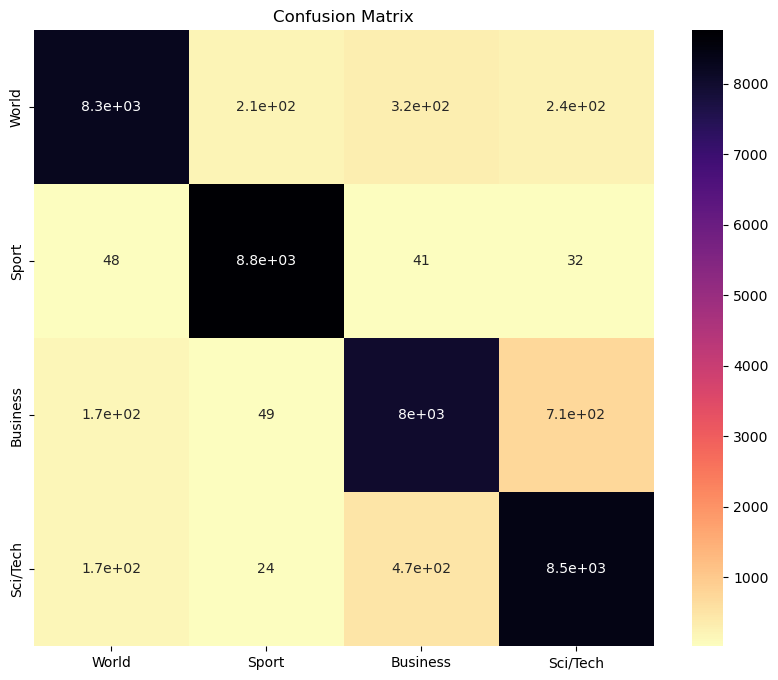

In [44]:
plt.figure(figsize=(10,8))

# plot the heat map 
sns.heatmap(
    confusion_matrix(test_df['label'], preds_flat),
    annot=True,
    xticklabels=['World','Sport','Business','Sci/Tech'],
    yticklabels=['World','Sport','Business','Sci/Tech'],
    cmap=plt.cm.magma_r
)
plt.title('Confusion Matrix')
plt.show()